In [20]:
library(ggplot2)
#library(fmsb)
library(dplyr)
library(tidyr)
#library(ggforce)
library(tibble)
library(RColorBrewer)
#library(dynutils)
library(plyr)
library(stringr)
library(R.utils)

In [21]:
metrics_tab_lab <- read.csv("/storage/groups/ml01/workspace/group.daniela/metrics_lisi/all.csv")
methods <- colnames(metrics_tab_lab)[-1]
metrics <- as.character(metrics_tab_lab[,1])

metrics_tab <- t(metrics_tab_lab)
metrics_tab[metrics_tab == ""] <- NA
metrics_tab <- as.data.frame(metrics_tab[-1,])
colnames(metrics_tab) <- plyr::mapvalues(
    metrics,
    from = c("ASW_label", "ASW_label/batch", "cell_cycle_conservation"), 
    to = c("Cell type ASW", "Batch ASW", "CC conservation"))
colnames(metrics_tab) <- sub("_", " ", colnames(metrics_tab))

method_names <- sapply(str_split(rownames(metrics_tab), "_"), function(x) x[1])
method_names <- capitalize(method_names)
method_names <- plyr::mapvalues(method_names,
                                from = c("Seurat", "Bbknn", "Trvae"), 
                                to = c("Seurat v3", "BBKNN", "TrVAE"))

row_groups <- sapply(str_split(rownames(metrics_tab), "_"), function(x) x[2])

metrics_tab <- add_column(metrics_tab, "Method" = method_names, .before = 1)
bbknn_ind <- grep("bbknn", rownames(metrics_tab))
lisi_ind <- grep("LISI", colnames(metrics_tab))
metrics_tab[bbknn_ind, lisi_ind] <- NA

# reorder columns by groups
col.ordered <- c("Method", "PCR batch", "Batch ASW", "iLISI", "kBET", "NMI cluster/label", 
                 "ARI cluster/label", "Cell type ASW", "cLISI", "CC conservation")
metrics_tab <- metrics_tab[, col.ordered]

metrics_tab[,-1] <- as.numeric(as.matrix(metrics_tab[, -1]))
#metrics_tab[,-1] <- apply(metrics_tab[,-1], 2, function(x) scale_minmax(x))

score_group1 <- rowMeans(metrics_tab[, 2:5], na.rm = T)
score_group2 <- rowMeans(metrics_tab[, 6:10], na.rm = T)
score_all <- rowMeans(metrics_tab[, 2:10], na.rm = T)
metrics_tab <- add_column(metrics_tab, "Overall Score" = score_all, .after = "Method")
metrics_tab <- add_column(metrics_tab, "Batch Correction" = score_group1, .after = "Overall Score")
metrics_tab <- add_column(metrics_tab, "Bio conservation" = score_group2, .after = "kBET")

metrics_tab <- add_column(metrics_tab, "method_group" = row_groups, .after = "Method")


# order methods by the overall score
if(length(unique(score_all))!= 1){
  metrics_tab <- metrics_tab[order(metrics_tab$method_group, metrics_tab$`Overall Score`,  decreasing = T), ]
}

method_group <- plyr::mapvalues(metrics_tab$method_group, 
                                from = c("knn", "embed", "full"), 
                                to = c("KNN", "Embeddings", "Features"))
metrics_tab <- metrics_tab[, colnames(metrics_tab) != "method_group"]

In [22]:
metrics_tab

,Method,Overall Score,Batch Correction,PCR batch,Batch ASW,iLISI,kBET,Bio conservation,NMI cluster/label,ARI cluster/label,Cell type ASW,cLISI,CC conservation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bbknn_knn,BBKNN,0.6908039,0.9992721,NA,NA,NA,0.9992721,0.5365697,0.6870941,0.3860454,NA,NA,NA
scanorama_full,Scanorama,0.5811837,0.6679707,0.9009355,0.7737616,0.69994952,0.2972364,0.5117540,0.7264755,0.4863223,0.4743794,0.9019544,-0.03036149
seurat_full,Seurat v3,0.5652003,0.4354842,0.9479305,0.4513800,0.03864484,0.3039815,0.6689732,0.6916075,0.3869757,0.3710983,0.9612860,0.93389878
scanorama_embed,Scanorama,0.6102801,0.6766527,0.9025372,0.8078945,0.69994950,0.2962296,0.5571820,0.7362391,0.4920528,0.4920476,0.9019544,0.16361590
trvae_embed,TrVAE,0.5505859,0.4560655,0.8856113,0.5885881,0.07095247,0.2791101,0.6262022,0.6875210,0.3852733,0.4017801,0.8991782,0.75725830
harmony_embed,Harmony,0.4998955,0.3264401,0.5721720,0.4020211,0.03966866,0.2918988,0.6386597,0.7017138,0.3968200,0.3652859,0.9612860,0.76819280


In [23]:
orig_rownames = rownames(metrics_tab)
metrics_tab$Method = paste(metrics_tab$Method, sapply(strsplit(orig_rownames, '_'), `[`, 2))
rownames(metrics_tab) = metrics_tab$Method
metrics_tab

,Method,Overall Score,Batch Correction,PCR batch,Batch ASW,iLISI,kBET,Bio conservation,NMI cluster/label,ARI cluster/label,Cell type ASW,cLISI,CC conservation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BBKNN knn,BBKNN knn,0.6908039,0.9992721,NA,NA,NA,0.9992721,0.5365697,0.6870941,0.3860454,NA,NA,NA
Scanorama full,Scanorama full,0.5811837,0.6679707,0.9009355,0.7737616,0.69994952,0.2972364,0.5117540,0.7264755,0.4863223,0.4743794,0.9019544,-0.03036149
Seurat v3 full,Seurat v3 full,0.5652003,0.4354842,0.9479305,0.4513800,0.03864484,0.3039815,0.6689732,0.6916075,0.3869757,0.3710983,0.9612860,0.93389878
Scanorama embed,Scanorama embed,0.6102801,0.6766527,0.9025372,0.8078945,0.69994950,0.2962296,0.5571820,0.7362391,0.4920528,0.4920476,0.9019544,0.16361590
TrVAE embed,TrVAE embed,0.5505859,0.4560655,0.8856113,0.5885881,0.07095247,0.2791101,0.6262022,0.6875210,0.3852733,0.4017801,0.8991782,0.75725830
Harmony embed,Harmony embed,0.4998955,0.3264401,0.5721720,0.4020211,0.03966866,0.2918988,0.6386597,0.7017138,0.3968200,0.3652859,0.9612860,0.76819280


In [24]:
library(pheatmap)

In [25]:
as.matrix(metrics_tab[,3:ncol(metrics_tab)])

,Batch Correction,PCR batch,Batch ASW,iLISI,kBET,Bio conservation,NMI cluster/label,ARI cluster/label,Cell type ASW,cLISI,CC conservation
BBKNN knn,0.9992721,NA,NA,NA,0.9992721,0.5365697,0.6870941,0.3860454,NA,NA,NA
Scanorama full,0.6679707,0.9009355,0.7737616,0.69994952,0.2972364,0.5117540,0.7264755,0.4863223,0.4743794,0.9019544,-0.03036149
Seurat v3 full,0.4354842,0.9479305,0.4513800,0.03864484,0.3039815,0.6689732,0.6916075,0.3869757,0.3710983,0.9612860,0.93389878
Scanorama embed,0.6766527,0.9025372,0.8078945,0.69994950,0.2962296,0.5571820,0.7362391,0.4920528,0.4920476,0.9019544,0.16361590
TrVAE embed,0.4560655,0.8856113,0.5885881,0.07095247,0.2791101,0.6262022,0.6875210,0.3852733,0.4017801,0.8991782,0.75725830
Harmony embed,0.3264401,0.5721720,0.4020211,0.03966866,0.2918988,0.6386597,0.7017138,0.3968200,0.3652859,0.9612860,0.76819280


In [26]:
library(repr)
options(repr.plot.width=5, repr.plot.height=3)

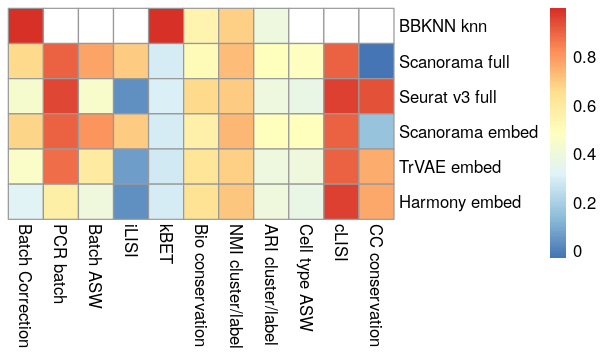

In [27]:
p = pheatmap(as.matrix(metrics_tab[,3:ncol(metrics_tab)]),
         na_col = "white", cluster_rows=FALSE, cluster_cols=FALSE)

In [28]:
library(data.table)

In [29]:
met_dt = as.data.table(metrics_tab)
met_dt[, HVG_label := NULL]

Warning message in `[.data.table`(met_dt, , `:=`(HVG_label, NULL)):
“Column 'HVG_label' does not exist to remove”

In [30]:
typeof(melt(met_dt, variable.name = 'Metrics')$value)

Warning message in melt.data.table(met_dt, variable.name = "Metrics"):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Method]. Consider providing at least one of 'id' or 'measure' vars in future.”

[1] "double"

Warning message in melt.data.table(met_dt, variable.name = "Metrics"):
“To be consistent with reshape2's melt, id.vars and measure.vars are internally guessed when both are 'NULL'. All non-numeric/integer/logical type columns are considered id.vars, which in this case are columns [Method]. Consider providing at least one of 'id' or 'measure' vars in future.”Warning message:
“Removed 6 rows containing missing values (geom_text).”

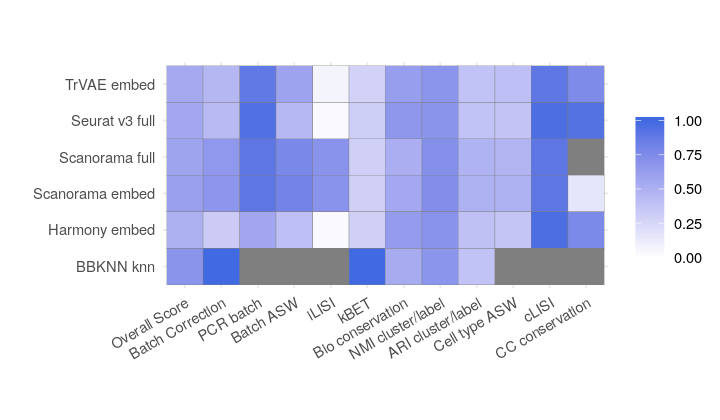

Saving 6.67 x 6.67 in image


ERROR: Error in loadNamespace(name): there is no package called ‘svglite’


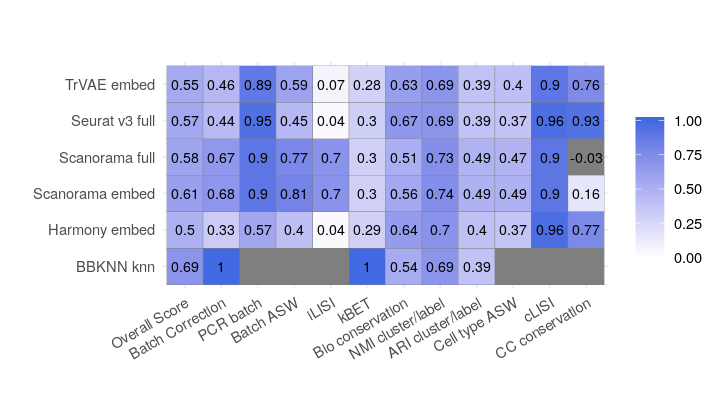

In [41]:
options(repr.plot.width=6, repr.plot.height=3.5)

title="Integration Performance Scores"
ggheatmap <- ggplot(data = melt(met_dt, variable.name = 'Metrics'), aes(x=Metrics, y=Method, fill=value)) + 
    geom_tile(color = "grey50")+
    scale_fill_gradient2(high = "royalblue", low = "lightgoldenrodyellow", #mid = "lightgoldenrodyellow", midpoint = 0.5,
        limit = c(0,1), space = "Lab", name="") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust = 1)) +
    labs(title="", x = "", y = "") +
    coord_fixed()

print(ggheatmap)

ggheatmap + geom_text(aes(Metrics, Method, label = round(value,2)), size = 3)

ggsave(paste0(getwd(), '/score_heatmap.svg'), p, device = 'svg')

In [42]:
file.exists(paste0(getwd(), '/score_heatmap.svg'))

[1] FALSE

In [70]:
subset(data, is.na(value))

Method,Metrics,value
<chr>,<fct>,<dbl>
BBKNN knn,PCR batch,NA
BBKNN knn,Batch ASW,NA
BBKNN knn,iLISI,NA
BBKNN knn,Cell type ASW,NA
BBKNN knn,cLISI,NA
BBKNN knn,CC conservation,NA
